# Coca-cola Stocks
* Basic prediction methods (ARIMA, SARIMAX, etc.)
* Deep Learning (RNN, LSTM, GRU, BiLSTM, BiGRU)
* Prediction with scraped data from Google Finance
* Create a trend line of candle stick chart wherein each data point represents the value of Open, High, Low, and Close.

**Dataset Source:** _https://finance.yahoo.com/quote/KO_

In [ ]:
!pip install pmdarima
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 11.9 MB/s eta 0:00:00


In [ ]:
# Data Manipulation and Presentation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# Statsmodels modules (Non-DL Modeling)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Auto ARIMA
from pmdarima import auto_arima

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import meanabs
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# To access Google Drive
from google.colab import drive

# Other libraries
from itertools import combinations
from datetime import datetime, timedelta

## Part 1
* Reading the file as a dataframe
* Data Exploration and Cleaning
* Stationarity Test 1: Augmented-Dickey Fuller (ADF) Test
* Stationarity Test 2: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


### Reading the file as a Dataframe

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
filepath = '/content/drive/MyDrive/Data Science Portfolio Projects/Coca-cola_stocks/KO_yahoo.csv'
data = pd.read_csv(filepath)

### Data Exploration and Cleaning

In [ ]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.047763,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.046699,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.047053,844800
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.045989,1420800
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.045516,2035200


In [ ]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
15659,2024-03-19,60.240002,60.349998,60.060001,60.230000,60.230000,15030600
15660,2024-03-20,60.180000,60.810001,60.160000,60.750000,60.750000,15258800
15661,2024-03-21,60.560001,60.990002,60.320000,60.470001,60.470001,13067100
15662,2024-03-22,60.520000,60.790001,60.430000,60.490002,60.490002,11501400
15663,2024-03-25,60.480000,60.709999,60.119999,60.400002,60.400002,13143500


The scope of the data is from January 02, 1962 to March 25, 2024

In [ ]:
# Check info (data types and counts)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15664 entries, 0 to 15663
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15664 non-null  object 
 1   Open       15664 non-null  float64
 2   High       15664 non-null  float64
 3   Low        15664 non-null  float64
 4   Close      15664 non-null  float64
 5   Adj Close  15664 non-null  float64
 6   Volume     15664 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 856.8+ KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15664.000000,15664.000000,15664.000000,15664.000000,15664.000000,1.566400e+04
mean,17.674044,17.816505,17.528074,17.678130,12.351685,9.241174e+06
std,18.610037,18.743471,18.471186,18.611250,15.839437,7.947289e+06
min,0.192708,0.193359,0.182292,0.192057,0.035360,7.680000e+04
25%,0.877604,0.885417,0.872396,0.877604,0.230336,3.011700e+06
50%,10.312500,10.406250,10.218750,10.312500,4.880804,7.915300e+06
75%,30.945312,31.291875,30.572188,30.968750,17.391630,1.319320e+07
max,67.000000,67.199997,65.720001,66.209999,62.319374,1.241690e+08


In [ ]:
# Extract the date part only from 'Date' column and convert it to datetime format
data_preprocessed = data.copy()
data_preprocessed['Date'] = pd.to_datetime(data['Date'].str.split(' ').str[0])

In [ ]:
data_preprocessed.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2329,1971-05-10,1.023438,1.028646,1.020833,1.023438,0.226028,528000
567,1964-04-03,0.333984,0.337240,0.333333,0.333333,0.064389,614400
8534,1995-11-27,18.812500,18.843750,18.593750,18.656250,9.168392,5248000
6046,1986-01-24,1.645833,1.679688,1.630208,1.671875,0.672569,14702400
14933,2021-04-29,53.540001,54.360001,53.430000,54.259998,49.543545,15391000


In [ ]:
data_preprocessed.set_index('Date', inplace=True)

In [ ]:
data_daily = data_preprocessed.resample('D').last()

Number of NaN records: 7065
Shape of daily dataset: (22729, 6)



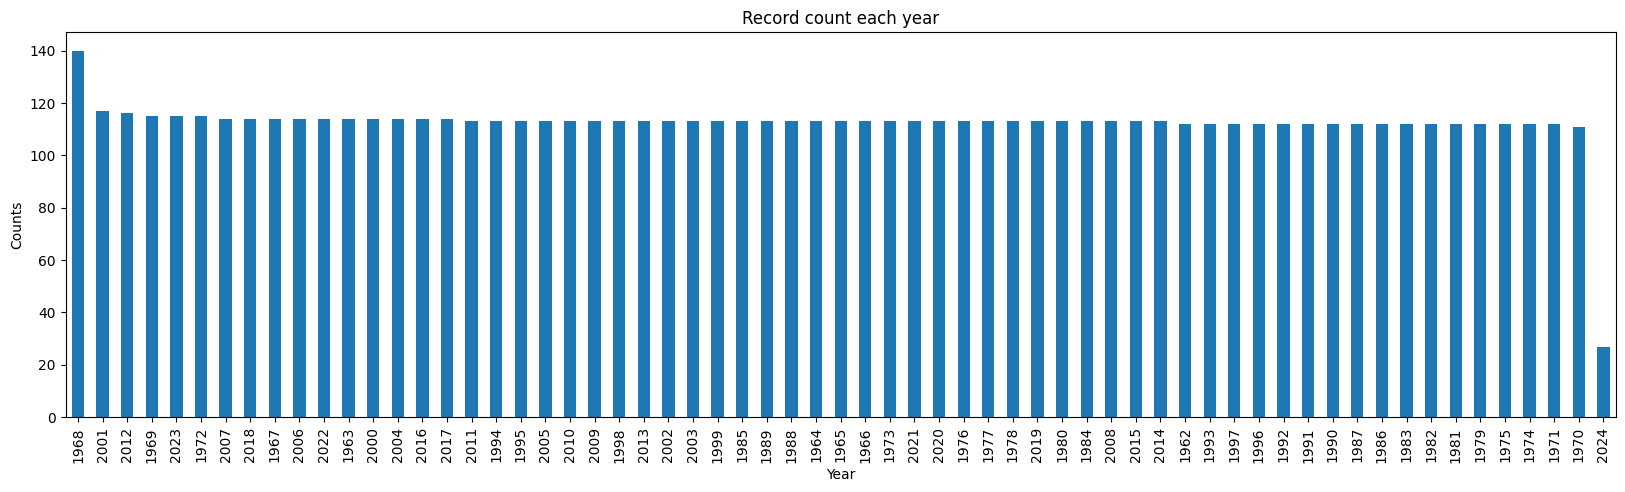

In [ ]:
data_daily[data_daily['Close'].isna()].index.year.value_counts().plot.bar(figsize=(20, 5))

print(f"Number of NaN records: {data_daily['Close'].isna().sum()}")
print(f"Shape of daily dataset: {data_daily.shape}\n")

plt.title("Record count each year")
plt.xlabel("Year")
plt.ylabel("Counts")
plt.show()

* As of the usage of the data in this notebook, the latest record was on October 26, 2022. We would like to check if the the number of records each year is equal or nearly equal to each other.

* As can be seen, there is a significant difference between the data recorded from 1962 compared to other years especially even excluding 2022 as the year was not yet completed.

* Moreover, even though the record count in each year located in the middle seem to be near each other, they are actually not.

* I asked for reasons why on Stackoverflow and had a response that there are no trading every weekends and holidays.

* Thus, even though I would like to analyze and make a model with it with daily frequency or intervals, I will make it monthly instead. With this compromise, the data we will be working with will not have NaN values.

* If you have better suggestions on how to address NaN values given the context of stock market data with respect to data analysis and time series modeling, feel free to provide or comment.

Number of NaN records: 0
Shape of monthly dataset: (747, 6)



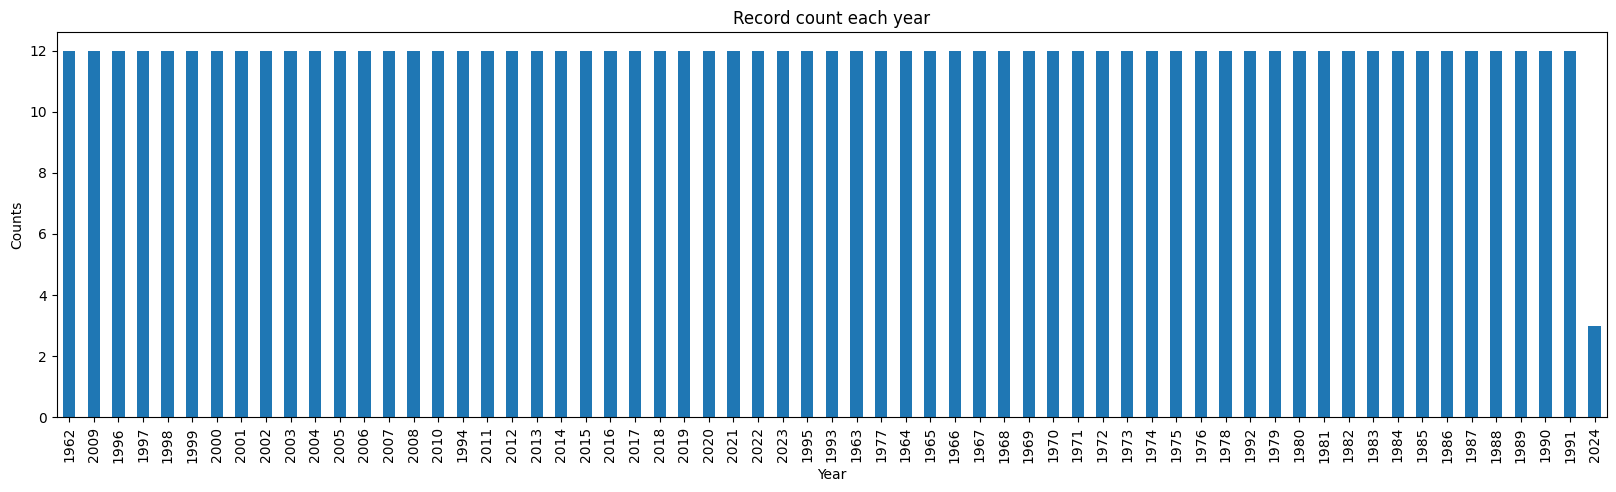

In [ ]:
data_monthly = data_preprocessed.resample('M').last()

print(f"Number of NaN records: {data_monthly['Close'].isna().sum()}")
print(f"Shape of monthly dataset: {data_monthly.shape}\n")

data_monthly[data_monthly['Close'].notna()].index.year.value_counts().plot.bar(figsize=(20, 5))
plt.title("Record count each year")
plt.xlabel("Year")
plt.ylabel("Counts")
plt.show()

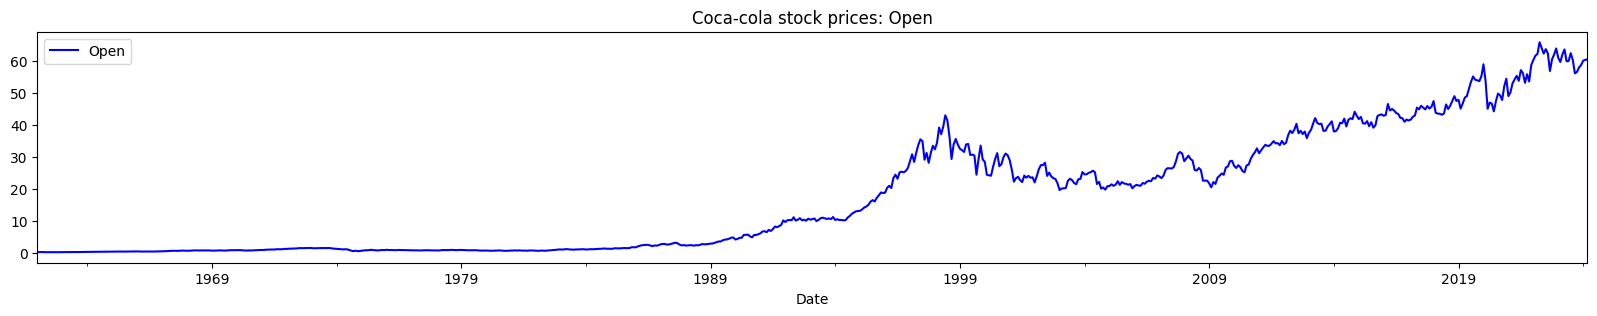

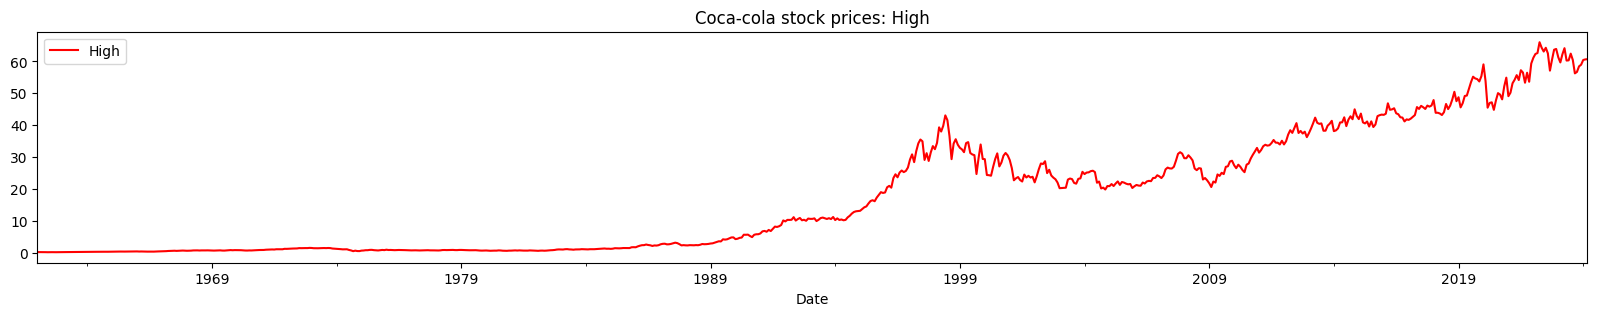

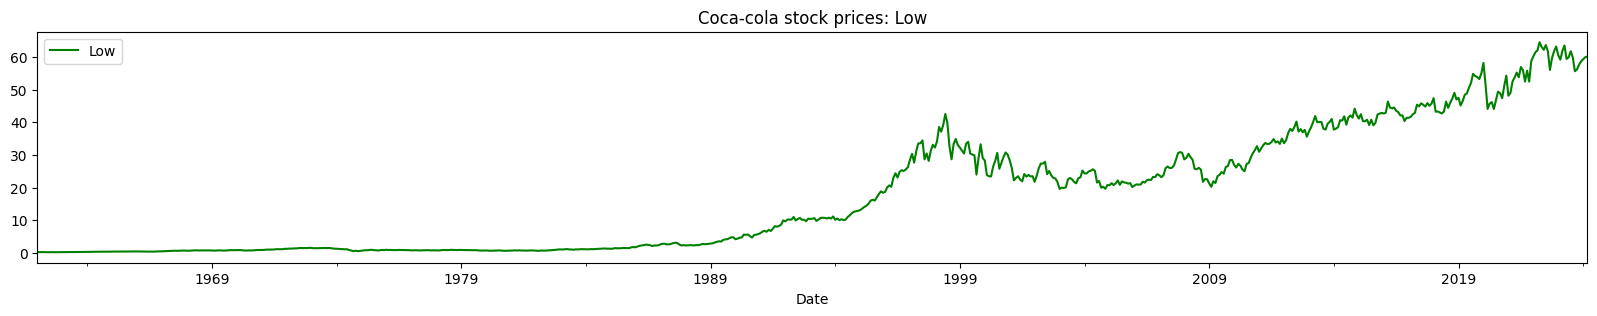

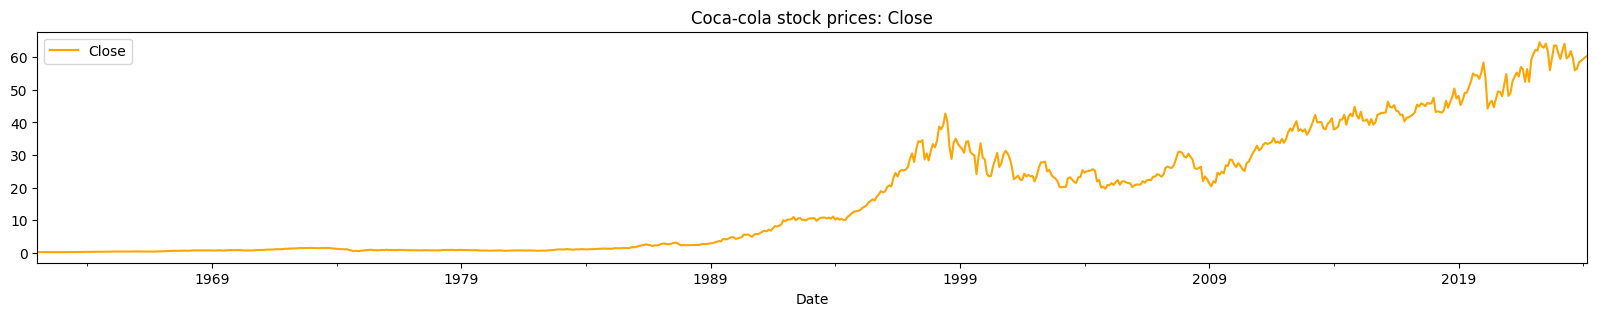

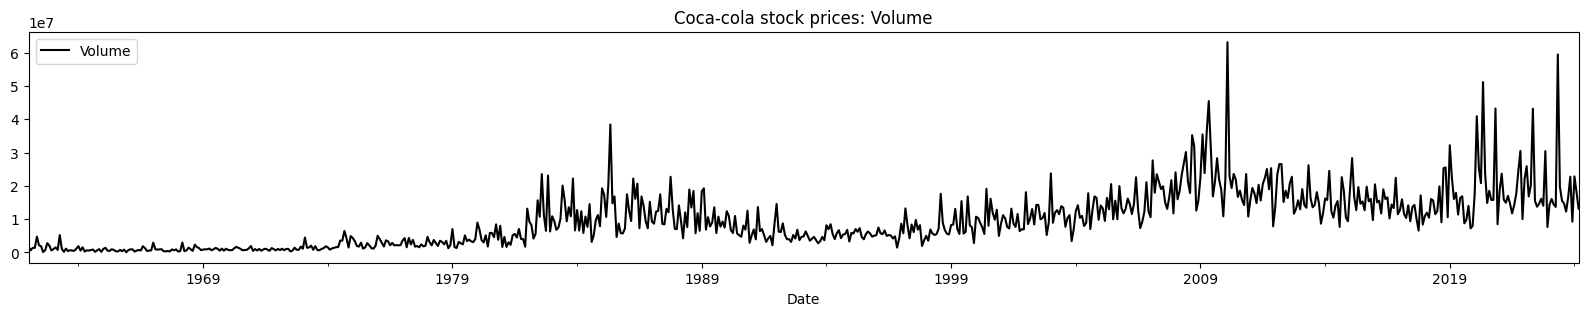

In [ ]:
# Plot the Open, High, Low, and Close columns with respect to Date
colors = ['blue', 'red', 'green', 'orange', 'black']
for column, color in zip(list(data_monthly.columns[:4]) + [data_monthly.columns[-1]], colors):
  ax = data_monthly.plot(y=column, label=column, color=color, figsize=(20,3))
  ax.set_title(f'Coca-cola stock prices: {column}')
  plt.show()

The difference between the Open, High, Low, and Close are very minimal which can be observed directly from the line graphs above. Thus, I will use the "Close" column for the succeeding analyses. I will also use that feature or column for the modeling.

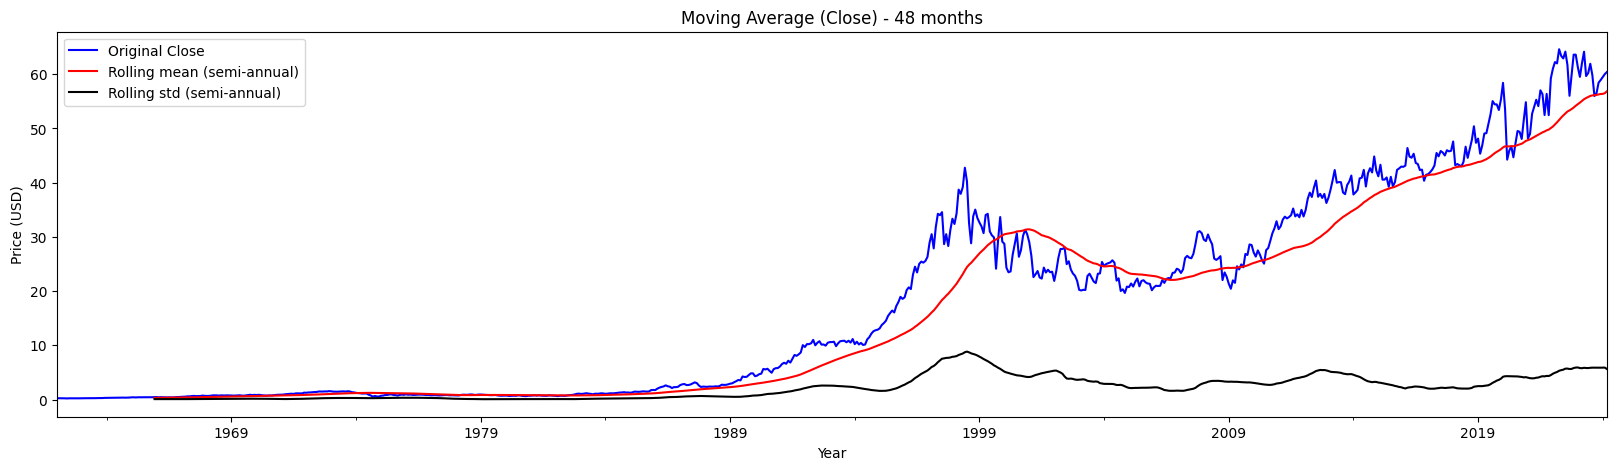

In [ ]:
# Semi-annual lag (approximately)
rolling_mean = data_monthly['Close'].rolling(48).mean()
rolling_std = data_monthly['Close'].rolling(48).std()

data_monthly_copy = data_monthly.copy()
data_monthly_copy['rolling_mean'] = rolling_mean
data_monthly_copy['rolling_std'] = rolling_std

ax = data_monthly_copy.plot(y='Close', color='blue', label='Original Close', figsize=(20,5))
data_monthly_copy.plot(y='rolling_mean', color='red', label='Rolling mean (semi-annual)', ax=ax)
data_monthly_copy.plot(y='rolling_std', color='black', label='Rolling std (semi-annual)', ax=ax)

plt.title("Moving Average (Close) - 48 months")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.show()

I calculated the rolling or moving average and standard deviation (std) with 7 years or 84 months as the window size for "Close" and "Volume". I chose this value to clearly see the trend with minimal noise as I can comprehend it. Also, it is between 10% and 25% of the number of records. Here is what I inferred from the graph:
* During the early years, the stock prices for Coca-cola was cheap and the volumes were relatively low.
* In the 1980s, the volumes increased significantly. However, the stock prices only began increasing in the 1990s. Perhaps it was from the popularity of advertising at that time, especially the Internet being accessible. Moreover, based on Britannica (https://www.britannica.com/topic/The-Coca-Cola-Company), this was the year that the company added new beverages and importing products to other countries (i.e., East Germary and India.)
* In 1990s, the stock prices continued to increase but the volume decreased.
* For the 20th century, the stock prices continued to increase which skyrocketed up until the present. The volume had slight variations but had an all-time highest at the 21st century.
* There are more volumes of stocks in the 21st century compared to the previous generations.
* With the stock prices increasing since the 1990s, there were not much of a significant variation as can be seen on the rolling std graph until mid-1990s until the present which means that there was a great shift in its general price at that time. For the volume, there was a noticeable changes in 1980s, 2000s, and 2010s.

### Stationarity Test 1: Augmented-Dickey Fuller (ADF) Test


ADF test is conducted with the following assumptions:

* Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
* Alternate Hypothesis(HA): Series is stationary, or series has no unit root.

Conditions to Reject Null Hypothesis(H0):

If **(Test statistic < Critical Value) and (p-value < 0.05)**, **Reject Null Hypothesis(HO)**, i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.

*Reference: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/*

In [ ]:
# ADF Test for Closing Prices
adft = adfuller(data_monthly['Close'], autolag="AIC")

adft_results = pd.DataFrame({
    'Values': [adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
    'Metric' : ["ADF Test Statistics", "p-value", "No. of lags used", "Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]
})

adft_results.set_index('Metric')

,Values
Metric,
ADF Test Statistics,0.502857
p-value,0.984960
No. of lags used,20.000000
Number of observations used,726.000000
critical value (1%),-3.439389
critical value (5%),-2.865529
critical value (10%),-2.568894


**(ADF Test Statistics (3.104616) > -2.865625) AND (p-value (1.000000) > 0.05) = Accept Null Hypothesis (Non-stationary)**

With the confidence level at 5%, we accept the ADF test's null hypothesis - non-stationary. Because the ADF Test Statistic value is greater than the critical value. Likewise, the p-value is greater than 5% or 0.05.

Thus, the time series data is non-stationary.

### Stationarity Test 2: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The KPSS test is conducted with the following assumptions.

* Null Hypothesis (HO): Series is trend stationary or series has no unit root.
* Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.

*Note: The hypothesis is reversed in the KPSS test compared to ADF Test.*

Conditions to Accept Null Hypothesis(H0)

If the **(Test Statistic < Critical Value) and (p-value < 0.05), Accept Null Hypothesis(H0)**, i.e., time series does not have a unit root, meaning it is trend stationary.


*Reference: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/*

In [ ]:
# KPSS Test for Closing Prices
kpsst = kpss(data_monthly['Close'])

kpsst_results = pd.DataFrame({
    'Values': [kpsst[0], kpsst[1], kpsst[2], kpsst[3]['1%'], kpsst[3]['2.5%'], kpsst[3]['5%'], kpsst[3]['10%']],
    'Metric' : ["KPSS Test Statistics", "p-value", "No. of lags used", "critical value (1%)", "critical value (2.5%)", "critical value (5%)", "critical value (10%)"]
})

kpsst_results.set_index('Metric')

<ipython-input-19-cbfef3ea2b79>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsst = kpss(data_monthly['Close'])


,Values
Metric,
KPSS Test Statistics,3.741048
p-value,0.010000
No. of lags used,17.000000
critical value (1%),0.739000
critical value (2.5%),0.574000
critical value (5%),0.463000
critical value (10%),0.347000


**(KPSS Test Statistics (3.741048) > 0.146000) AND (p-value (0.463000) < 0.05) =  Reject Null Hypothesis (Non-stationary)**

With the confidence level at 5%, we reject the KPSS test's null hypothesis - stationary. Because the ADF Test Statistic value is greater than the critical value despite of p-value being less than 5% or 0.05.

Thus, we opt for the alternative hypothesis making the time series data non-stationary.

## Part 2
* Time series modeling with ARIMA and SARIMAX
* Time series modeling with Deep Learning using LSTM

#### Time series modeling with ARIMA and SARIMAX

##### Converting Non-stationary Series to Stationary Series and Stationarity Verification

* Differencing method (1st order) was used to convert the non-stationary time series data to stationary. It is performed by performing element-wise subtraction between the original data and the original data that is lagged by n-days which in this case is 1. This order or lag is increased until the data becomes stationary. The final value will be the value used for the parameter **"d"**
* After that, the stationary time series data will be used to create the ACF and PACF plot to determine the values for the parameters **"p"** and **"q"**. These two represent the order of AR and MA in ARIMA.

In [ ]:
data_monthly_close_transformed = data_monthly['Close'].diff().dropna() # Perform 1st order differencing and drop null values

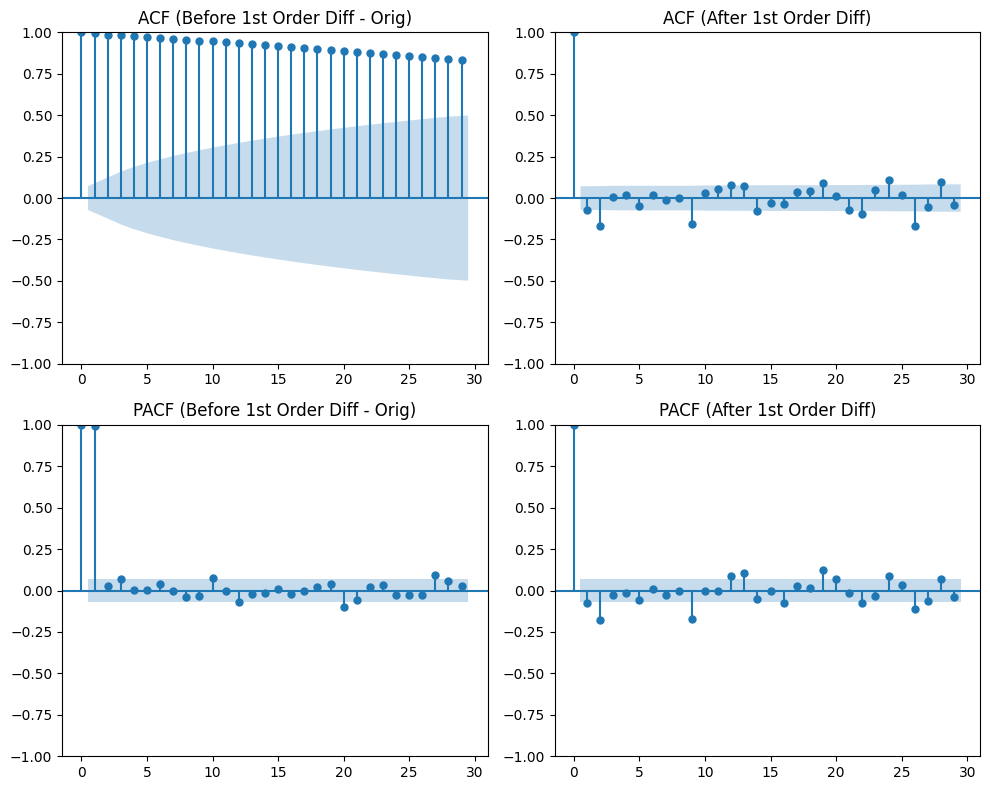

In [ ]:
# Create a figure and axis object with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plotting ACF of data_monthly['Close'] in the first column
plot_acf(data_monthly['Close'], ax=axs[0, 0])
axs[0, 0].set_title('ACF (Before 1st Order Diff - Orig)')

# Plotting PACF of data_monthly['Close'] in the first column
plot_pacf(data_monthly['Close'], ax=axs[1, 0])
axs[1, 0].set_title('PACF (Before 1st Order Diff - Orig)')

# Plotting ACF of data_monthly_close_transformed in the second column
plot_acf(data_monthly_close_transformed, ax=axs[0, 1])
axs[0, 1].set_title('ACF (After 1st Order Diff)')

# Plotting PACF of data_monthly_close_transformed in the second column
plot_pacf(data_monthly_close_transformed, ax=axs[1, 1])
axs[1, 1].set_title('PACF (After 1st Order Diff)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# ADF Test for Stock Closing Prices
adft = adfuller(data_monthly_close_transformed, autolag="AIC")

adft_results = pd.DataFrame({
    'Values': [adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
    'Metric' : ["ADF Test Statistic", "p-value", "No. of lags used", "Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]
})

adft_results.set_index('Metric')

,Values
Metric,
ADF Test Statistic,-5.120198
p-value,0.000013
No. of lags used,19.000000
Number of observations used,726.000000
critical value (1%),-3.439389
critical value (5%),-2.865529
critical value (10%),-2.568894


**(ADF Test Statistics (-5.120198) < -2.865529) AND (p-value (0.000013) < 0.05) =  Reject Null Hypothesis (Stationary)**

With the confidence level at 5%, we reject the ADF test's null hypothesis - stationary. Because the ADF Test Statistic value is less than the critical value at 5% and the p-value is less than 5% or 0.05.

Thus, we opt for the null hypothesis making the time series data stationary.

In [ ]:
# KPSS Test for Stock Volumes
kpsst = kpss(data_monthly_close_transformed)

kpsst_results = pd.DataFrame({
    'Values': [kpsst[0], kpsst[1], kpsst[2], kpsst[3]['1%'], kpsst[3]['2.5%'], kpsst[3]['5%'], kpsst[3]['10%']],
    'Metric' : ["KPSS Test Statistics", "p-value", "No. of lags used", "critical value (1%)", "critical value (2.5%)", "critical value (5%)", "critical value (10%)"]
})

kpsst_results.set_index('Metric')

<ipython-input-24-10bb1803bedd>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsst = kpss(data_monthly_close_transformed)


,Values
Metric,
KPSS Test Statistics,0.305455
p-value,0.100000
No. of lags used,11.000000
critical value (1%),0.739000
critical value (2.5%),0.574000
critical value (5%),0.463000
critical value (10%),0.347000


**(KPSS Test Statistics (0.305455) < 0.347000) AND (p-value (0.1) <= 0.1) =  Accept Null Hypothesis (Stationary)**

With the confidence level at 10%, we accept the KPSS test's null hypothesis - stationary.

Based on an answer from a [question](https://stats.stackexchange.com/questions/518458/kpss-test-p-value-greater-than-0-05-but-test-statistic-is-less-than-critical-va) from StackExchange, in this situation where the KPSS test statistic value is less than the critical values and the p-value is greater than 0.05 or 5%, the null hypothesis can still be accepted (i.e., fail to reject) at 10% level of confidence.

Thus, we opt for the null hypothesis making the time series data stationary.

**Identifying the values of p, q, and d for ARIMA**

The decision-making for p and q values is arbitrary. But based on my knowledge, here are the rules:
* The value of p is derived from PACF
* The value of q is derived from ACF
* The region in the middle is the correlation threshold which means that points that are inside have relatively low correlation and are insignificant. Thus, we focus on those points that are outside the region.
* All of the points outside the region can be indicators for the value of p and q. However, the larger it is, the more complicated the model will be.
* Generally, I prefer to keep the model as simple as possible especially if there are no significant difference from increasing the p and q values.

Now, for deciding the p value:
* Looking at the PACF plot, the highest point seems to be at the second line. Thus, let us consider **p=2**.

Next, for deciding the q value:
* Looking at the ACF plot, the highest point seems to be at the 2nd and 26th line. Since I prefer to make the model simple to lessen complexity, let us consider **q=2**.

Also, we applied first-order differencing which was enough to make the time series data stationary. Thus, let us consider **d=1**.

##### Training and Evaluation

**Metrics**

* Mean Absolute Error (MAE)
* Mean Squared Error (MSE)
* Root Mean Squared Error (RMSE)
* Mean Absolute Percentage Error (MAPE)
* Symmetric Mean Absolute Percentage Error (SMAPE)
* Mean Absolute Scaled Error (MASE)


*Reference: https://mlpills.dev/time-series/error-metrics-for-time-series-forecasting/*

In [ ]:
"""
Class that returns the summary of error metrics
Attributes:
  - actual: test data split in a series or list
  - pred: predictions in a series or list
  - train: training data split in a series or list
"""
class TimeSeriesMetrics():

  def __init__(self, actual, pred, train):
    self.actual = actual
    self.pred = pred
    self.train = train

  def symmetric_mean_absolute_percentage_error(self):
    return f"{round(2 * np.mean(np.abs(self.actual - self.pred) / (np.abs(self.actual) + np.abs(self.pred))) * 100, 4)}%"

  def return_summary(self):
    mae = round(mean_absolute_error(self.actual, self.pred), 4)
    mse = round(mean_squared_error(self.actual, self.pred), 4)
    rmse = round(np.sqrt(mse), 4)
    mape = f"{round(mean_absolute_percentage_error(self.actual, self.pred) * 100, 4)}%"
    smape = self.symmetric_mean_absolute_percentage_error()
    mase = mean_absolute_scaled_error(self.actual, self.pred, y_train=self.train)

    contents = {
        'Value' : [mae, mse, rmse, mape, smape, mase]
    }

    return pd.DataFrame(contents, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'SMAPE', 'MASE'])

###### ARIMA

The last 48 months (i.e., two years worth) of data was considered as test data while the remaining are for fitting the model to.

In [ ]:
train = data_monthly['Close'][:-48]
test = data_monthly['Close'][-48:]

In [ ]:
# Fit the training data to the ARIMA model
close_arima_model = ARIMA(train, order=(2, 1, 2)) # p=2, d=1, q=2
close_arima_model_trained = close_arima_model.fit()

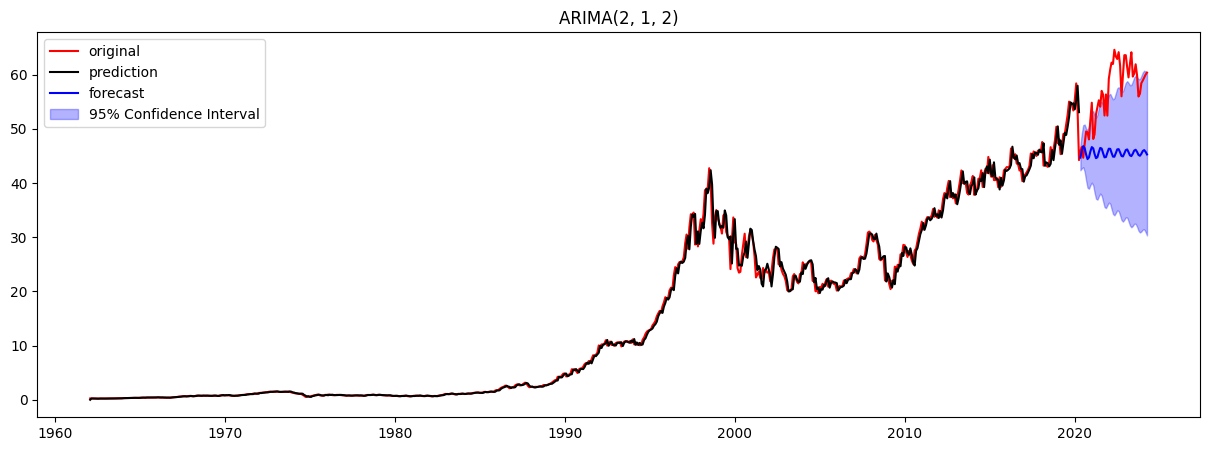

In [ ]:
predictions_train = close_arima_model_trained.predict() # Predictions with respect to training data
prediction_test_results = close_arima_model_trained.get_forecast(steps=len(test)) # In sample test prediction ARIMA object results object
predictions_test = close_arima_model_trained.forecast(len(test)) # Actual in sample predictions with respect to training data
confidence_interval_test_preds = prediction_test_results.conf_int() # Confidence interval from in sample test prediction ARIMA results object

# Plotting
plt.figure(figsize=(15,5))
plt.plot(data_monthly['Close'], color='red', label='original')
plt.plot(predictions_train, color='black', label='prediction')
plt.plot(predictions_test, color='blue', label='forecast')
plt.fill_between(confidence_interval_test_preds.index, confidence_interval_test_preds.iloc[:, 0], confidence_interval_test_preds.iloc[:, 1], color='blue', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title("ARIMA(2, 1, 2)")
plt.show()

ARIMA Model Evaluation for Closing Stock Prices

In [ ]:
close_arima_model_results = TimeSeriesMetrics(test, predictions_test, train)
close_arima_model_results.return_summary()

,Value
MAE,11.3371
MSE,157.5945
RMSE,12.5537
MAPE,19.1601%
SMAPE,21.6185%
MASE,17.929114


###### SARIMAX

Normally, I use the same p, d, and q values for P, D, and Q parameters respectively for the seasonal order. Given that the data is monthly, m=12. The common method of finding the optimal seasonal order is through Auto ARIMA or exhaustive search, similar to the idea of GridSearchCV in the context of hyperparameter optimization in conventional machine learning models.

In [ ]:
close_sarimax_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
close_sarimax_model_trained = close_sarimax_model.fit()

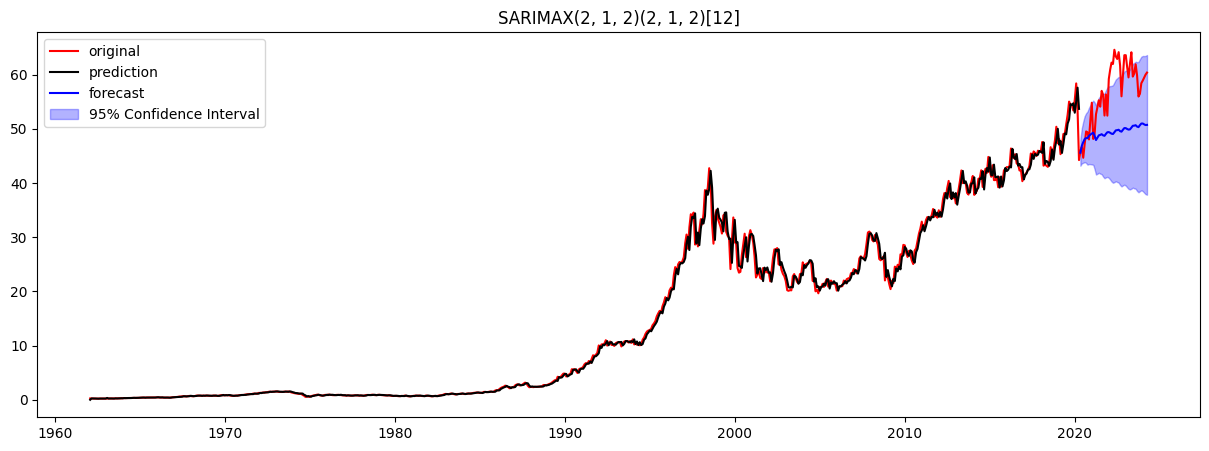

In [ ]:
predictions_train = close_sarimax_model_trained.predict()
prediction_test_results = close_sarimax_model_trained.get_forecast(steps=len(test))
predictions_test = close_sarimax_model_trained.forecast(len(test))
confidence_interval_test_preds = prediction_test_results.conf_int()

plt.figure(figsize=(15,5))
plt.plot(data_monthly['Close'], color='red', label='original')
plt.plot(predictions_train, color='black', label='prediction')
plt.plot(predictions_test, color='blue', label='forecast')
plt.fill_between(confidence_interval_test_preds.index, confidence_interval_test_preds.iloc[:, 0], confidence_interval_test_preds.iloc[:, 1], color='blue', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title("SARIMAX(2, 1, 2)(2, 1, 2)[12]")
plt.show()

SARIMAX Model Evaluation for Closing Stock Prices

In [ ]:
close_sarimax_model_results = TimeSeriesMetrics(test, predictions_test, train)
close_sarimax_model_results.return_summary()

,Value
MAE,7.6843
MSE,78.8387
RMSE,8.8791
MAPE,12.8678%
SMAPE,14.0242%
MASE,12.15233


###### AUTO-ARIMA

Now, using the automatic way of finding the values for non-seasonal order (p, d, and q) and seasonal order (P, D, and Q), auto_arima() from pmdarima library will be used.

It returns the fitted arima model but in this case, we aim to acquire the parameter values using the whole data, not with the training data split. Thus, another set of ARIMA and SARIMAX models will be trained based on the provided values by auto_arima().

In [ ]:
auto_arima_model = auto_arima(data_monthly['Close'],
                      m=12,               # frequency of series
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2587.359, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2592.796, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2586.208, Time=0.69 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2584.618, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2593.369, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2588.409, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2580.026, Time=1.28 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2583.203, Time=0.40 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=2576.813, Time=2.45 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2575.265, Time=1.06 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2582.682, Time=1.00 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2565.460, Time=2.78 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2570.721, Time=1.03 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=2567.125, Time=5.94 sec
 ARIMA(1,1,1)(1,0,1

Based on the output, here are the optimal values for the following parameters:
* p = 2
* d = 1
* q = 0
* P = 2
* D = 0
* Q = 0
* m = 12 (Given that the data is monthly)

In [ ]:
close_arima_model_second = ARIMA(train, order=(2, 1, 0))
close_arima_model_second_trained = close_arima_model.fit()

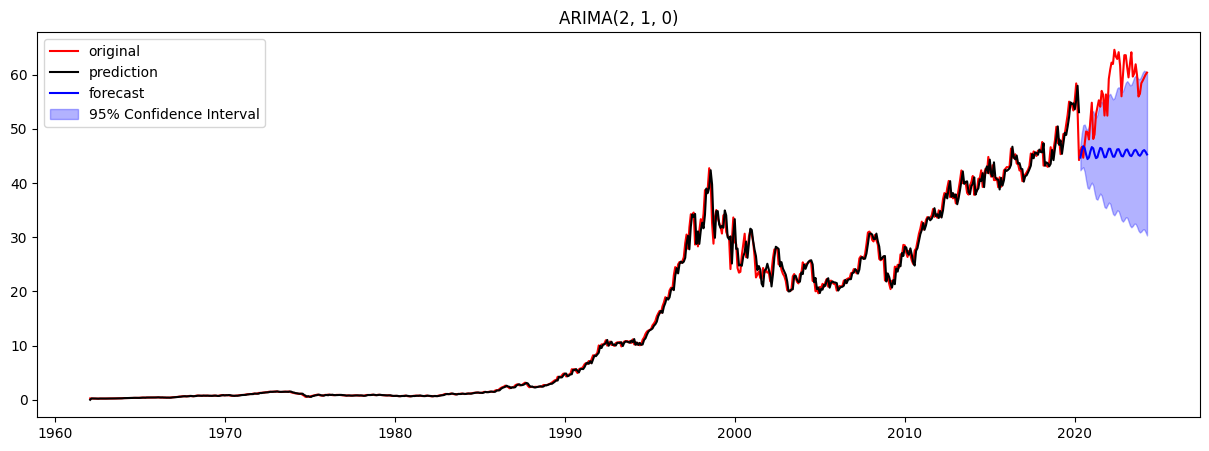

In [ ]:
predictions_train = close_arima_model_second_trained.predict()
prediction_test_results = close_arima_model_second_trained.get_forecast(steps=len(test))
predictions_test = close_arima_model_second_trained.forecast(len(test))
confidence_interval_test_preds = prediction_test_results.conf_int()

plt.figure(figsize=(15,5))
plt.plot(data_monthly['Close'], color='red', label='original')
plt.plot(predictions_train, color='black', label='prediction')
plt.plot(predictions_test, color='blue', label='forecast')
plt.fill_between(confidence_interval_test_preds.index, confidence_interval_test_preds.iloc[:, 0], confidence_interval_test_preds.iloc[:, 1], color='blue', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title("ARIMA(2, 1, 0)")
plt.show()

In [ ]:
close_arima_model_second_results = TimeSeriesMetrics(test, predictions_test, train)
close_arima_model_second_results.return_summary()

,Value
MAE,11.3371
MSE,157.5945
RMSE,12.5537
MAPE,19.1601%
SMAPE,21.6185%
MASE,17.929114


In [ ]:
close_sarimax_second_model = SARIMAX(train, order=(2, 1, 0), seasonal_order=(2, 0, 0, 12))
close_sarimax_second_model_trained = close_sarimax_second_model.fit()

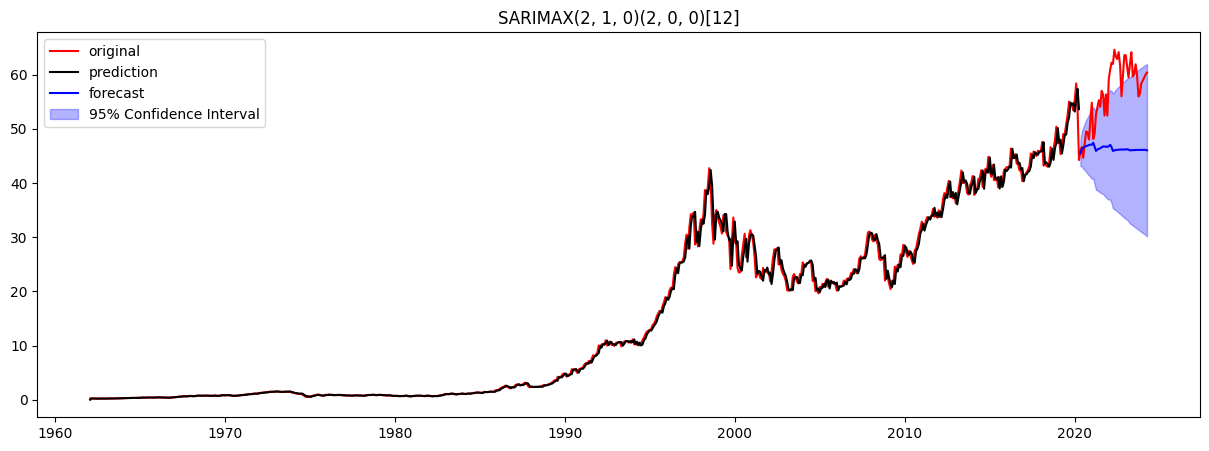

In [ ]:
predictions_train = close_sarimax_second_model_trained.predict()
prediction_test_results = close_sarimax_second_model_trained.get_forecast(steps=len(test))
predictions_test = close_sarimax_second_model_trained.forecast(len(test))
confidence_interval_test_preds = prediction_test_results.conf_int()

plt.figure(figsize=(15,5))
plt.plot(data_monthly['Close'], color='red', label='original')
plt.plot(predictions_train, color='black', label='prediction')
plt.plot(predictions_test, color='blue', label='forecast')
plt.fill_between(confidence_interval_test_preds.index, confidence_interval_test_preds.iloc[:, 0], confidence_interval_test_preds.iloc[:, 1], color='blue', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title("SARIMAX(2, 1, 0)(2, 0, 0)[12]")
plt.show()

In [ ]:
close_sarimax_model_second_results = TimeSeriesMetrics(test, predictions_test, train)
close_sarimax_model_second_results.return_summary()

,Value
MAE,10.5367
MSE,142.5754
RMSE,11.9405
MAPE,17.6957%
SMAPE,19.8914%
MASE,16.663249


Summary for Non-Deep Learning Time Series Models

In [ ]:
pd.DataFrame({
    'ARIMA (2, 1, 2)' : close_arima_model_results.return_summary().iloc[:, 0],
    'ARIMA (2, 1, 0)' : close_arima_model_second_results.return_summary().iloc[:, 0],
    'SARIMAX (2, 1, 2)(2, 1, 2)[12]' : close_sarimax_model_results.return_summary().iloc[:, 0],
    'SARIMAX (2, 1, 0)(2, 0, 0)[12]' : close_sarimax_model_second_results.return_summary().iloc[:, 0]
}).transpose()

,MAE,MSE,RMSE,MAPE,SMAPE,MASE
"ARIMA (2, 1, 2)",11.3371,157.5945,12.5537,19.1601%,21.6185%,17.929114
"ARIMA (2, 1, 0)",11.3371,157.5945,12.5537,19.1601%,21.6185%,17.929114
"SARIMAX (2, 1, 2)(2, 1, 2)[12]",7.6843,78.8387,8.8791,12.8678%,14.0242%,12.15233
"SARIMAX (2, 1, 0)(2, 0, 0)[12]",10.5367,142.5754,11.9405,17.6957%,19.8914%,16.663249


The dataframe above shows the comparison of error metrics based on the predictions made on the test data.

The ARIMA(2, 1, 2)and ARIMA(2, 1, 0) had the same error metric values. Thus, there was no significant difference in the ARIMA model with parameters defined by me compared to the model with paramters defined by Auto ARIMA.

The SARIMAX(2, 1, 2)(2, 1, 2)[12] was better than SARIMAX(2, 1, 0)(2, 0, 0)[12]. Thus, the model that was manually defined was better compared to the model that was based on the output of Auto ARIMA.

From all the models, SARIMAX(2, 1, 2)(2, 1, 2)[12], had the lowest error metric values. Thus, it is the best performing non-deep learning time series model up to this point.

#### Time series modeling with Deep Learning
Framework: PyTorch
* Long-Term Short-Term (LSTM)

In [ ]:
train = data_monthly['Close'][:-48]
test = data_monthly['Close'][-48:] # Set the last 48 months as the test data split

train_reshaped = np.reshape(train, (-1, 1)) # Reshaping
test_reshaped = np.reshape(test, (-1, 1))

print(f"Training Data Shape: {train_reshaped.shape}")
print(f"Testing Data Shape: {test_reshaped.shape}")

Training Data Shape: (699, 1)
Testing Data Shape: (48, 1)


In [ ]:
# Scaling the data to lessen the range of magnitude which affect the training results
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_reshaped)
scaled_test = scaler.transform(test_reshaped)

In [ ]:
"""
Helper function that generates a set of features and targets from a time series data split.
The approach becomes supervised learning
It returns two PyTorch tensors for the features and targets
"""
def create_dataset(data_split, lookback=1):

  X_train, y_train = [], []

  for i in range(len(data_split) - lookback):
    feature = data_split[i : i+lookback]
    target = data_split[i+1 : i+lookback+1]
    X_train.append(feature)
    y_train.append(target)

  return torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train))

In [ ]:
# Creating the feature and target for each split

X_train, y_train = create_dataset(scaled_train, lookback=3)
X_test, y_test = create_dataset(scaled_test, lookback=3)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_test shape: {y_test.shape}")

X_train shape: torch.Size([696, 3, 1])
y_train shape: torch.Size([696, 3, 1])
X_test shape: torch.Size([45, 3, 1])
X_test shape: torch.Size([45, 3, 1])


In [ ]:
# LSTM Model
class LSTMModel(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.linear(out)
    return out

In [ ]:
# Check for the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [ ]:
# Set the attributes for the LSTM Model
input_dim = 1
hidden_size = 50
num_layers = 1

# Create an instance of the Model
model = LSTMModel(input_dim, hidden_size, num_layers).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
batch_size = 4 # Set batch size

loss_fn = nn.MSELoss() # Set loss metric
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Set optimizer
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size) # Create data loader

In [ ]:
n_epochs = 500 # Set training epochs
# Container of loss values
train_losses = []
test_losses = []

for epoch in range(n_epochs + 1):
  ### TRAINING ###
  model.train() # Set to train mode

  # Train in batches
  for X_batch, y_batch in loader:
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad() # Zero out the gradients
    loss.backward() # Calculate the gradients
    optimizer.step() # Adjust the parameter values according to the gradient

  # Display error metrics every 10 epochs
  if epoch % 10 != 0:
    continue

  ### EVALUATION ###
  model.eval() # Set to evaluation mode
  with torch.no_grad(): # Set to no_grad() to avoid gradient change during prediction
    # Make predictions based on training data and get the loss
    y_pred = model(X_train)
    loss_train = np.sqrt(loss_fn(y_pred, y_train)).item()
    train_losses.append(loss_train)
    y_pred = model(X_test)
    # Make predictions based on test data and get the loss
    loss_test = np.sqrt(loss_fn(y_pred, y_test)).item()
    test_losses.append(loss_test)

  # Display the metrics
  print(f"Epoch: {epoch} | Train Loss: {round(loss_train, 4)} | Test Loss: {round(loss_test, 4)}")

Epoch: 0 | Train Loss: 0.1401 | Test Loss: 0.3942
Epoch: 10 | Train Loss: 0.0221 | Test Loss: 0.0603
Epoch: 20 | Train Loss: 0.0219 | Test Loss: 0.0605
Epoch: 30 | Train Loss: 0.0207 | Test Loss: 0.0481
Epoch: 40 | Train Loss: 0.0207 | Test Loss: 0.048
Epoch: 50 | Train Loss: 0.0211 | Test Loss: 0.0467
Epoch: 60 | Train Loss: 0.0211 | Test Loss: 0.0543
Epoch: 70 | Train Loss: 0.0205 | Test Loss: 0.0487
Epoch: 80 | Train Loss: 0.0228 | Test Loss: 0.047
Epoch: 90 | Train Loss: 0.0223 | Test Loss: 0.0624
Epoch: 100 | Train Loss: 0.0263 | Test Loss: 0.0635
Epoch: 110 | Train Loss: 0.0204 | Test Loss: 0.0507
Epoch: 120 | Train Loss: 0.0218 | Test Loss: 0.048
Epoch: 130 | Train Loss: 0.0205 | Test Loss: 0.0504
Epoch: 140 | Train Loss: 0.0217 | Test Loss: 0.0595
Epoch: 150 | Train Loss: 0.0209 | Test Loss: 0.047
Epoch: 160 | Train Loss: 0.0208 | Test Loss: 0.0536
Epoch: 170 | Train Loss: 0.0223 | Test Loss: 0.0487
Epoch: 180 | Train Loss: 0.0205 | Test Loss: 0.0518
Epoch: 190 | Train Loss: 0.

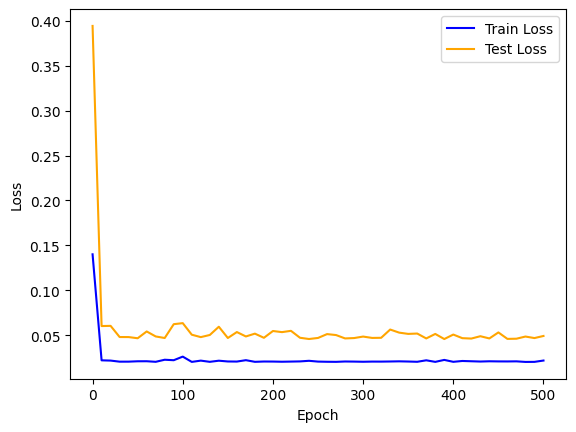

In [ ]:
# Plotting the loss values
plt.plot(range(0, 501, 10), train_losses, color="blue", label="Train Loss")
plt.plot(range(0, 501, 10), test_losses, color="orange", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

After the first 10 epochs, the loss decreased sharply and fluctuated until the end of the training. Nevertheless, the graph seems to indicated the model trained well with the train loss being lower than the test loss as expected.

In [ ]:
# Get the predictions with respect to training and test data

lookback = 3 # Lookback sequence

with torch.no_grad():
  train_pred_lstm = pd.DataFrame({
      'Close' : scaler.inverse_transform(model(X_train)[:, -1, :].detach().numpy()).reshape(-1)
  }, index=list(train.index)[lookback:])


  test_pred_lstm = pd.DataFrame({
      'Close' : scaler.inverse_transform(model(X_test)[:, -1, :].detach().numpy()).reshape(-1)
  }, index=list(test.index)[:-1*lookback])

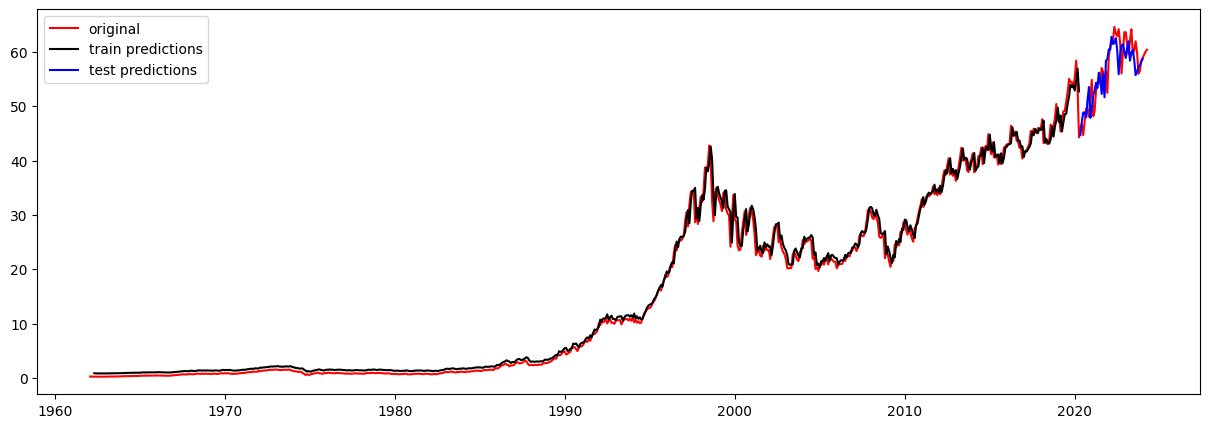

In [ ]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(data_monthly['Close'], color="red", label="original")
plt.plot(train_pred_lstm.iloc[:, 0], color="black", label="train predictions")
plt.plot(test_pred_lstm.iloc[:, 0], color="blue", label="test predictions")
plt.legend()
plt.show()

The test predictions seems to fit the original data nicely compared to previous models.

In [ ]:
# Calculate error metrics
predictions_test = test_pred_lstm.iloc[:, 0]
close_lstm_model_results = TimeSeriesMetrics(test[:-1*lookback], predictions_test, train[lookback:])
close_lstm_model_results.return_summary()

,Value
MAE,2.4862
MSE,10.0087
RMSE,3.1637
MAPE,4.4289%
SMAPE,4.4487%
MASE,3.915116


## Part 3

* Summary and Conclusion
* Forecasting with the Best Model

### Summary and Conclusion

In [ ]:
pd.DataFrame({
    'ARIMA (2, 1, 2)' : close_arima_model_results.return_summary().iloc[:, 0],
    'ARIMA (2, 1, 0)' : close_arima_model_second_results.return_summary().iloc[:, 0],
    'SARIMAX (2, 1, 2)(2, 1, 2)[12]' : close_sarimax_model_results.return_summary().iloc[:, 0],
    'SARIMAX (2, 1, 0)(2, 0, 0)[12]' : close_sarimax_model_second_results.return_summary().iloc[:, 0],
    'LSTM' : close_lstm_model_results.return_summary().iloc[:, 0]
}).transpose()

,MAE,MSE,RMSE,MAPE,SMAPE,MASE
"ARIMA (2, 1, 2)",11.3371,157.5945,12.5537,19.1601%,21.6185%,17.929114
"ARIMA (2, 1, 0)",11.3371,157.5945,12.5537,19.1601%,21.6185%,17.929114
"SARIMAX (2, 1, 2)(2, 1, 2)[12]",7.6843,78.8387,8.8791,12.8678%,14.0242%,12.15233
"SARIMAX (2, 1, 0)(2, 0, 0)[12]",10.5367,142.5754,11.9405,17.6957%,19.8914%,16.663249
LSTM,2.4862,10.0087,3.1637,4.4289%,4.4487%,3.915116


The table or DataFrame above shows the summary of error metrics based on the predictions and corresponding actual test values. For all metrics, the lower the value, the better.

With LSTM having the least error values, it is deemed as the best model for this case followed by SARIMAX(2, 1, 2)(2, 1, 2)[12]. Moreover, the ARIMA models seemed to be the worst performing models.

### Forecasting with the Best Model (LSTM)

In [ ]:
forecasts_lstm = [] # Container of forecast values

# Initialize the initial input with the last test data
input_data = y_test[-1].expand([1, lookback, 1])

# Use a loop to iteratively predict and transform
for i in range(8):
    with torch.no_grad():
        # Predict using the model and transform the output
        output = model(input_data)
        pred = scaler.inverse_transform(output.detach().numpy().reshape(-1, 1))

        # Print the last predicted value
        forecasts_lstm.append(pred[-1][0])

        # Prepare the next input for the next iteration
        input_data = torch.Tensor(scaler.transform(pred)).expand([1, lookback, 1])

In [ ]:
dates_to_predict = [] # Container of dates to predict

# Define the start date as the last date entry in the test split
start_date = datetime(2023, 12, 31)

# Print the last day of each month for the next twelve months
for i in range(8):
    # Calculate the last day of the current month
    last_day_of_month = start_date + timedelta(days=31)
    last_day_of_month = last_day_of_month.replace(day=1) - timedelta(days=1)


    dates_to_predict.append(last_day_of_month.strftime('%Y-%m-%d'))

    # Move to the next month
    start_date = last_day_of_month + timedelta(days=1)

In [ ]:
# Match the dates to predict with the corresponding forecasted values
lstm_forecasts_df = pd.DataFrame({
    'Close' : forecasts_lstm
}, index=[pd.Timestamp(x) for x in dates_to_predict])

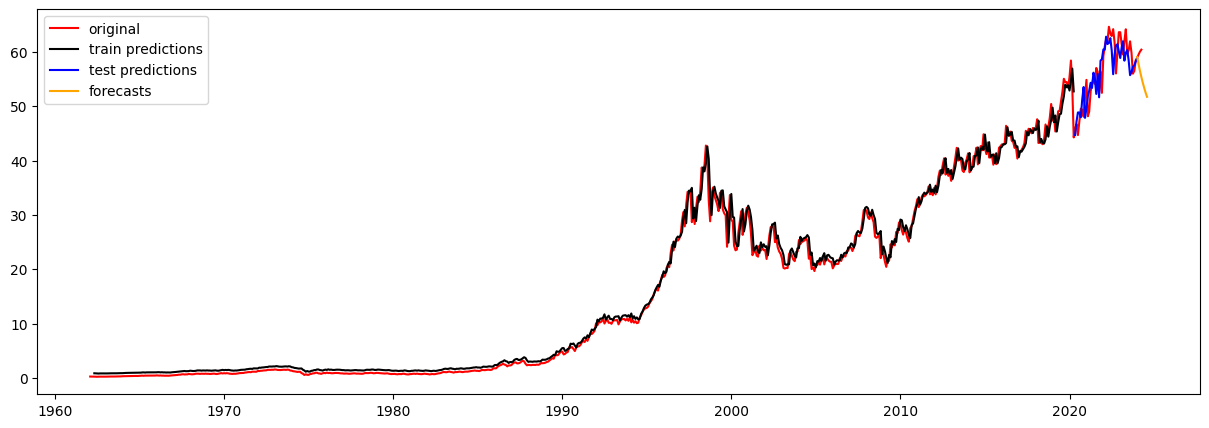

In [ ]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(data_monthly['Close'], color="red", label="original")
plt.plot(train_pred_lstm.iloc[:, 0], color="black", label="train predictions")
plt.plot(test_pred_lstm.iloc[:, 0], color="blue", label="test predictions")
plt.plot(lstm_forecasts_df.iloc[:, 0], color="orange", label="forecasts")
plt.legend()
plt.show()

The trend of forecast for the succeeding months is downward. Due to the process of lookback, the number of test predictions was lessened by the same amount of lookback sequence which in this case is 3. Thus, three preceeding forecasts were generated before the subsequent 5-month forecast.

It is important to note that this forecast is not conclusive as the behavior of stock prices is very volatile and unpredictable.

Also, in contrast to technical way of analyzing stock market, **Random Walk Theory** suggests that stock prices move unpredictably or randomly and past prices cannot be used to predict future prices.

_Reference: https://www.investopedia.com/terms/r/randomwalktheory.asp_